# Probabilistic Graph Model: Bayesian Network

Making inference on 'crime against property' data

### Context

The data set is a 5-year record of reported Robbery & Theft within Manila from 2010 - 2014. The idea is to leverage on its intrinsic probability distribution on selected discrete variables. The goal is to infer on future probable density of robbery & theft happening.

In [1]:
!pip install --upgrade pixiedust # for visualization/EDA, check documentation: https://pixiedust.github.io/pixiedust/displayapi.html
!pip install --upgrade pgmpy #for probabilistic graphical models, check documentations: https://github.com/pgmpy/pgmpy_notebook/blob/master/pdfs/Probabilistic%20Graphical%20Models%20using%20pgmpy.pdf
!pip install pyspark # for pixiedust data import and data manip
!pip install pandas_profiling # for quick dataset profiling/ EDA

Requirement already up-to-date: pixiedust in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.1.17)
     |████████████████████████████████| 296kB 271kB/s eta 0:00:01
     |████████████████████████████████| 1.3MB 45.2MB/s eta 0:00:01
  Found existing installation: networkx 2.2
    Uninstalling networkx-2.2:
      Successfully uninstalled networkx-2.2
     |████████████████████████████████| 215.6MB 51.0MB/s eta 0:00:01  |▏                               | 890kB 325kB/s eta 0:10:59
     |████████████████████████████████| 204kB 42.1MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/8d/20/f0/b30e2024226dc112e256930dd2cd4f06d00ab053c86278dcf3
Successfully built pyspark
     |████████████████████████████████| 133kB 310kB/s eta 0:00:01
     |████████████████████████████████| 614kB 934kB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Stored in directory: /home/dsxuser/.cache/pip/wheels

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
df_data.head()

date  week_of_month    month day_of_week time_of_crime    time_range  \
0  06/01/2010              1  January   Wednesday    9:00:00 PM  9 PM - 12 AM   
1  08/01/2010              2  January      Friday   12:00:00 PM  12 PM - 3 PM   
2  18/01/2010              3  January      Monday    2:00:00 PM  12 PM - 3 PM   
3  19/01/2010              3  January     Tuesday   10:00:00 AM  9 AM - 12 PM   
4  21/01/2010              3  January    Thursday    3:00:00 PM   3 PM - 6 PM   

      crime_location crime_type         property_loss       victim_occupation  \
0  Sta. Cruz, Manila    Robbery               Jewelry                 Manager   
1      Tondo, Manila      Theft  Electronics, Jewelry                 Manager   
2      Tondo, Manila      Theft                  Cash     Government Employee   
3     Ermita, Manila      Theft        Mechanic Tools                    none   
4   Sta. Ana, Manila      Theft         Cash, Gadgets  Human Resource Officer   

   victim_age victim_civilstatus victim_gender  suspect_count suspect_weapon  \
0        33.0            Married          Male              2           none   
1        31.0             Single        Female              1           none   
2        75.0            Married        Female              2           none   
3        32.0             Single          Male              2           none   
4        31.0            Married          Male              1           none   

  suspect_gender suspect_age  suspect_address  
0         Female          28    Caloocan City  
1         Female          22  Agusan, Del Sur  
2           Male      26, 30    Tondo, Manila  
3           Male          30   Ermita, Manila  
4         Female          32    Tondo, Manila

## Data pre-processing

In [4]:
#pre-req: pandas read data to df_data
import numpy as np
from pandas.api.types import CategoricalDtype
import calendar

#df_data['record_counter'] = 1

df_data['date']= pd.to_datetime(df_data['date'], format='%d/%m/%Y' )
df_data['time_of_crime'] = pd.to_datetime(df_data['time_of_crime'],format= '%I:%M:%S %p' ).dt.time
df_data['date'] = df_data.apply(lambda r : pd.datetime.combine(r['date'],r['time_of_crime']),1)

df_data['month'] = df_data.date.dt.month
df_data['month'] = df_data.month.apply(lambda x: calendar.month_abbr[x])

month_order = CategoricalDtype(categories=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
                               ordered = True)
day_order = CategoricalDtype(categories=["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"],
                               ordered = True)
time_range_order = CategoricalDtype(categories=["12 AM - 3 AM", "3 AM - 6 AM", "6 AM - 9 AM", "9 AM - 12 PM", "12 PM - 3 PM", "3 PM - 6 PM", "6 PM - 9 PM", "9 PM - 12 AM"],
                               ordered = True)

df_data.month = df_data.month.astype(month_order)
df_data.day_of_week = df_data.day_of_week.astype(day_order)
df_data.time_range = df_data.time_range.astype(time_range_order)

df_data.week_of_month = ('week' + df_data.week_of_month.astype(str)).astype('category')

df_data.loc[:, df_data.dtypes == object] = df_data.loc[:, df_data.dtypes == object].astype(str)

#### Dataset Profiling

In [197]:
import pandas_profiling

In [17]:
profile = pandas_profiling.ProfileReport(df_data)
display(profile)

## Exploratory Data Analysis

Visualizations

In [198]:
from pyspark.sql import SQLContext
from pyspark import SparkContext

sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

sdf = sqlContext.createDataFrame(df_data)
display(sdf)

DataFrame[date: timestamp, week_of_month: string, month: string, day_of_week: string, time_of_crime: string, time_range: string, crime_location: string, crime_type: string, property_loss: string, victim_occupation: string, victim_age: double, victim_civilstatus: string, victim_gender: string, suspect_count: bigint, suspect_weapon: string, suspect_gender: string, suspect_age: string, suspect_address: string]

In [265]:
import pixiedust

display(sdf)

In [9]:
sdf.registerTempTable("crime_df") #set as temp table to enable SQL queries
crime_df = sqlContext.sql("SELECT * FROM crime_df WHERE month='Dec'")

In [10]:
crime_df.count()

44


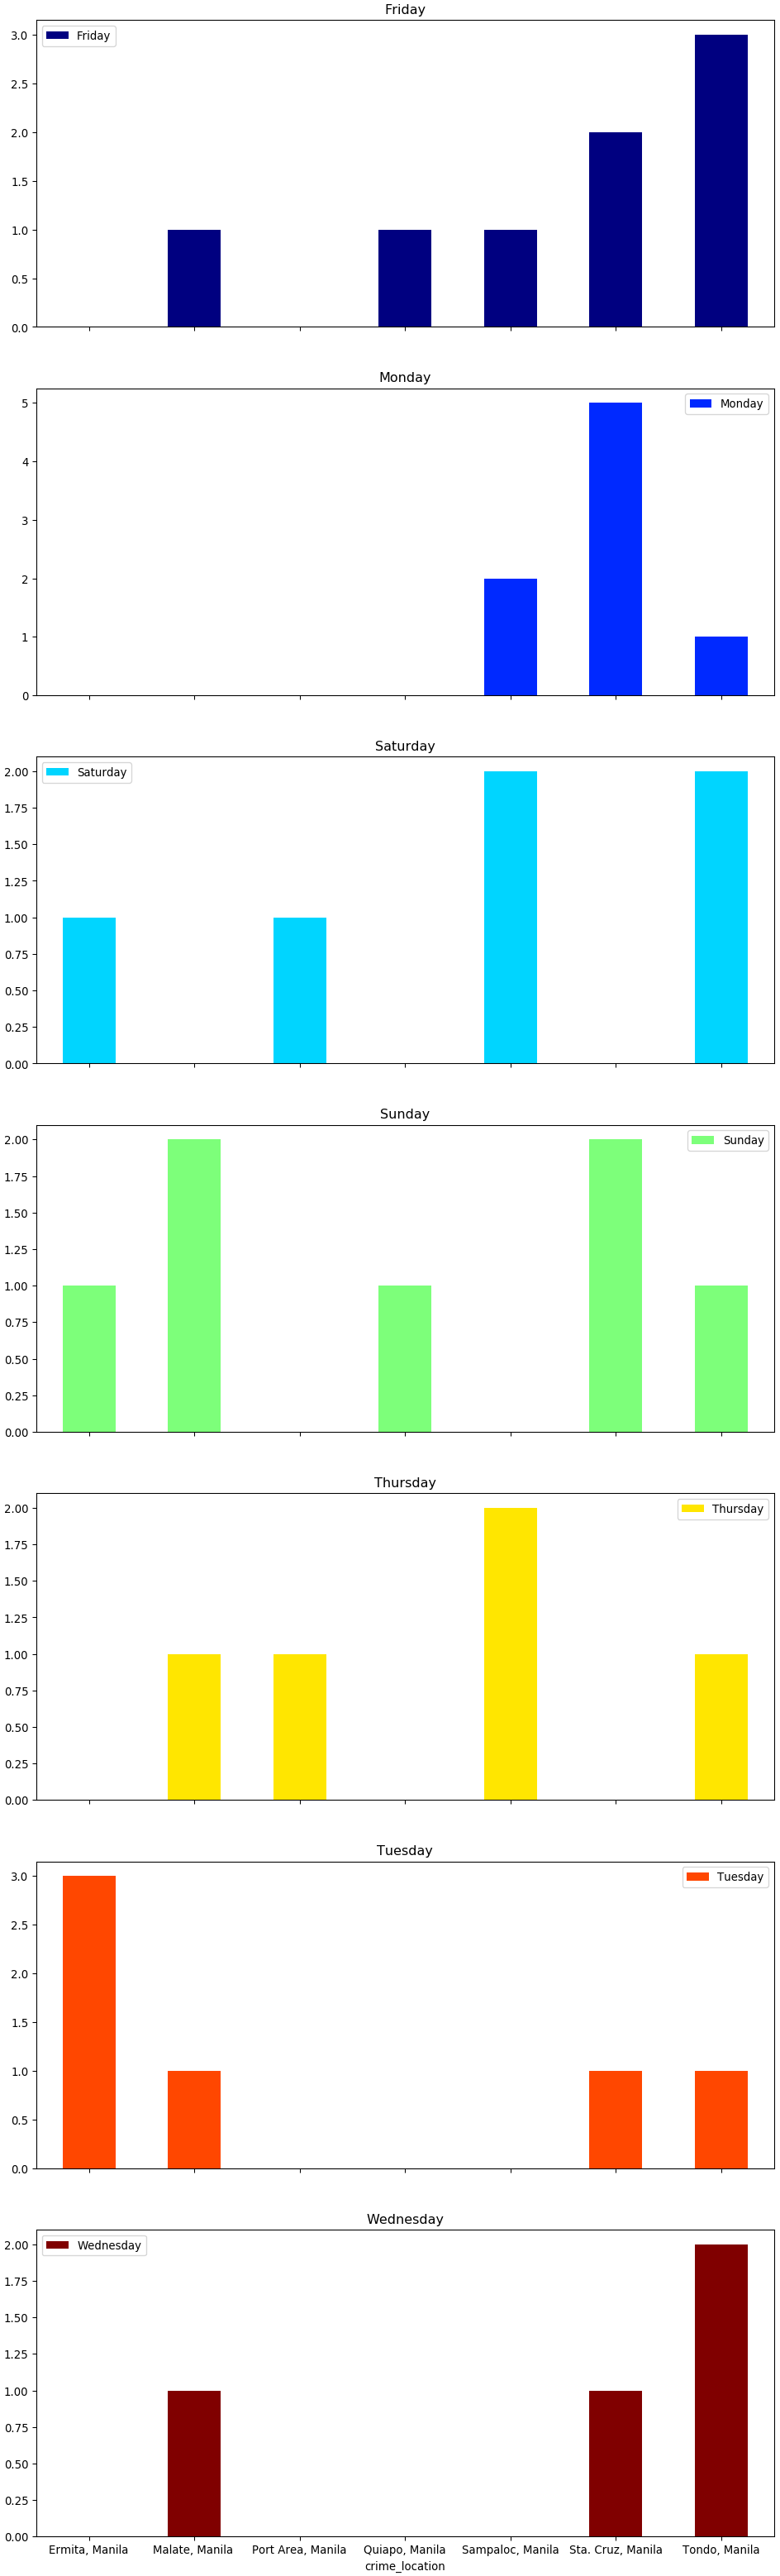

In [8]:
crime_df_agg = crime_df.groupby('time_range','crime_location','day_of_week').count()
display(crime_df_agg)

## Probabilistic Graphical Modeling

Bayesian Network implementation with 'pgmpy' package

In [5]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

#### Define network (model) structure

<img src="https://github.com/goodguynic/probabilistic_graphical_model/blob/master/BNmodel.jpg?raw=true" width="600"/>

In [6]:
#data_train = df_data.loc[:df_data.shape[0] , ['month', 'day_of_week', 'week_of_month', 'time_range', 'crime_location']]

model = BayesianModel([('month', 'day_of_week'),
                      ('week_of_month', 'day_of_week'),
                      ('time_range', 'crime_location'),
                      ('day_of_week', 'crime_location'),
                      ('crime_location', 'crime_against_property')])

#model.fit(data_train)

#### Define Conditional Probability Distribution of each node on our model structure

In [7]:
month_cpd = TabularCPD( variable = 'month',
                      variable_card = 12,
                      values = [[0.086168, 0.106576, 0.07483, 0.068027, 0.070295, 0.0839, 0.106576, 0.081633, 0.072562, 0.063492, 0.086168, 0.099773]])

In [8]:
week_cpd = TabularCPD( variable = 'week_of_month',
                     variable_card = 5,
                     values = [[0.185941, 0.283447, 0.226757, 0.235828, 0.068027]])

In [9]:
time_cpd = TabularCPD( variable = 'time_range',
                     variable_card = 8,
                     values = [[0.095238, 0.099773, 0.070295, 0.156463, 0.163265, 0.170068, 0.136054, 0.108844]])

In [10]:
loc_cpd = TabularCPD( variable = 'crime_location',
                    variable_card = 14,
                    values =[[0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.117647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000],
                             [0.166667,0.000000,0.000000,0.285714,0.000000,0.100000,0.200000,0.142857,0.500000,0.000000,0.000000,0.285714,0.125000,0.333333,0.000000,0.000000,0.250000,0.000000,0.000000,0.375000,0.125000,0.444444,0.230769,0.200000,0.000000,0.125000,0.000000,0.363636,0.166667,0.058824,0.400000,0.300000,0.000000,0.000000,0.100000,0.333333,0.461538,0.000000,0.000000,0.222222,0.375000,0.000000,0.000000,0.071429,0.166667,0.058824,0.000000,0.000000,0.222222,0.200000,0.000000,0.230769,0.090909,0.083333,0.000000,0.375000],
                             [0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000],
                             [0.000000,0.500000,0.000000,0.285714,0.125000,0.000000,0.100000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.400000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.076923,0.600000,0.000000,0.000000,0.000000,0.272727,0.166667,0.117647,0.000000,0.300000,0.000000,0.333333,0.000000,0.111111,0.000000,0.000000,0.222222,0.222222,0.000000,0.111111,0.000000,0.071429,0.166667,0.058824,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.125000],
                             [0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.111111,0.400000,0.000000,0.000000,0.000000,0.083333,0.000000,0.125000],
                             [0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.250000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.200000,0.000000,0.125000,0.125000,0.000000,0.153846,0.000000,0.400000,0.125000,0.000000,0.000000,0.083333,0.117647,0.000000,0.000000,0.333333,0.000000,0.200000,0.000000,0.076923,0.000000,0.000000,0.111111,0.125000,0.555556,0.142857,0.142857,0.000000,0.000000,0.125000,0.000000,0.111111,0.000000,0.333333,0.153846,0.000000,0.000000,0.000000,0.000000],
                             [0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000],
                             [0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.100000,0.142857,0.000000,0.000000,0.000000,0.142857,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.058824,0.000000,0.100000,0.000000,0.000000,0.100000,0.111111,0.076923,0.000000,0.111111,0.111111,0.000000,0.000000,0.142857,0.071429,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.166667,0.076923,0.090909,0.000000,0.000000,0.125000],
                             [0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.285714,0.000000,0.000000,0.000000,0.000000,0.125000,0.125000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.200000,0.000000,0.000000,0.000000,0.200000,0.111111,0.076923,0.000000,0.222222,0.000000,0.125000,0.000000,0.142857,0.000000,0.083333,0.176471,0.125000,0.000000,0.000000,0.000000,0.166667,0.153846,0.181818,0.166667,0.125000,0.000000],
                             [0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.100000,0.111111,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.076923,0.000000,0.083333,0.125000,0.125000],
                             [0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.200000,0.000000,0.000000,0.125000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.100000,0.000000,0.333333,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.222222,0.000000,0.071429,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.166667,0.000000,0.000000],
                             [0.000000,0.000000,0.000000,0.142857,0.125000,0.500000,0.400000,0.142857,0.250000,0.500000,0.000000,0.571429,0.375000,0.000000,0.142857,0.400000,0.250000,0.200000,0.500000,0.000000,0.125000,0.111111,0.307692,0.000000,0.000000,0.125000,0.000000,0.000000,0.083333,0.294118,0.200000,0.200000,0.000000,0.333333,0.100000,0.222222,0.153846,0.250000,0.000000,0.111111,0.375000,0.111111,0.142857,0.142857,0.250000,0.235294,0.125000,0.000000,0.000000,0.200000,0.000000,0.153846,0.272727,0.333333,0.250000,0.125000],
                             [0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000],
                             [0.333333,0.250000,0.000000,0.000000,0.625000,0.300000,0.100000,0.142857,0.000000,0.100000,0.000000,0.000000,0.500000,0.000000,0.285714,0.200000,0.000000,0.400000,0.000000,0.250000,0.375000,0.111111,0.230769,0.200000,0.400000,0.375000,0.000000,0.363636,0.333333,0.235294,0.200000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.250000,0.333333,0.222222,0.000000,0.000000,0.142857,0.285714,0.250000,0.352941,0.125000,0.500000,0.444444,0.200000,0.166667,0.153846,0.181818,0.083333,0.500000,0.000000]],
                    evidence = ['day_of_week', 'time_range'],
                    evidence_card = [7,8])

In [11]:
day_cpd = TabularCPD( variable = 'day_of_week',
                    variable_card = 7,
                    values =[[0.125000,0.000000,0.076923,0.090909,0.000000,0.200000,0.142857,0.090909,0.083333,0.142857,0.250000,0.066667,0.000000,0.250000,0.142857,0.000000,0.000000,0.166667,0.000000,0.142857,0.000000,0.100000,0.200000,0.000000,0.000000,0.100000,0.000000,0.333333,0.090909,0.142857,0.181818,0.083333,0.090909,0.125000,0.000000,0.000000,0.142857,0.166667,0.166667,0.142857,0.142857,0.000000,0.200000,0.083333,0.000000,0.142857,0.142857,0.000000,0.000000,0.285714,0.400000,0.153846,0.333333,0.125000,0.250000,0.166667,0.181818,0.250000,0.000000,0.125000],
                             [0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.214286,0.000000,0.083333,0.142857,0.250000,0.133333,0.200000,0.000000,0.142857,0.000000,0.083333,0.166667,0.111111,0.142857,0.000000,0.100000,0.200000,0.166667,0.000000,0.100000,0.000000,0.000000,0.090909,0.142857,0.090909,0.166667,0.090909,0.375000,0.200000,0.000000,0.071429,0.166667,0.000000,0.142857,0.000000,0.500000,0.000000,0.083333,0.500000,0.142857,0.142857,0.000000,0.000000,0.000000,0.100000,0.153846,0.333333,0.000000,0.000000,0.166667,0.090909,0.083333,0.285714,0.375000],
                             [0.250000,0.500000,0.153846,0.090909,0.000000,0.000000,0.071429,0.090909,0.083333,0.142857,0.000000,0.333333,0.200000,0.000000,0.142857,0.666667,0.083333,0.166667,0.222222,0.142857,0.000000,0.200000,0.200000,0.083333,0.000000,0.300000,0.000000,0.000000,0.181818,0.142857,0.000000,0.166667,0.000000,0.125000,0.200000,0.250000,0.142857,0.083333,0.000000,0.142857,0.000000,0.166667,0.000000,0.083333,0.000000,0.142857,0.000000,0.000000,0.250000,0.142857,0.000000,0.076923,0.000000,0.125000,0.250000,0.000000,0.272727,0.166667,0.142857,0.000000],
                             [0.125000,0.000000,0.153846,0.272727,0.000000,0.300000,0.285714,0.272727,0.416667,0.142857,0.000000,0.200000,0.100000,0.250000,0.142857,0.333333,0.166667,0.166667,0.222222,0.142857,0.500000,0.100000,0.000000,0.250000,0.500000,0.200000,0.000000,0.111111,0.090909,0.142857,0.090909,0.166667,0.000000,0.125000,0.000000,0.250000,0.214286,0.083333,0.000000,0.142857,0.285714,0.000000,0.400000,0.083333,0.000000,0.142857,0.285714,0.000000,0.250000,0.428571,0.100000,0.153846,0.000000,0.125000,0.000000,0.166667,0.000000,0.083333,0.142857,0.125000],
                             [0.125000,0.000000,0.230769,0.181818,0.500000,0.000000,0.214286,0.181818,0.000000,0.142857,0.500000,0.066667,0.000000,0.000000,0.142857,0.000000,0.083333,0.000000,0.000000,0.142857,0.000000,0.200000,0.200000,0.166667,0.000000,0.200000,0.285714,0.111111,0.181818,0.142857,0.090909,0.083333,0.363636,0.000000,0.400000,0.250000,0.142857,0.250000,0.500000,0.142857,0.000000,0.333333,0.000000,0.083333,0.500000,0.142857,0.142857,0.000000,0.000000,0.142857,0.200000,0.153846,0.000000,0.125000,0.250000,0.000000,0.181818,0.166667,0.142857,0.000000],
                             [0.125000,0.250000,0.153846,0.181818,0.500000,0.100000,0.071429,0.272727,0.166667,0.142857,0.000000,0.200000,0.200000,0.000000,0.142857,0.000000,0.250000,0.166667,0.333333,0.142857,0.000000,0.200000,0.000000,0.166667,0.500000,0.100000,0.428571,0.111111,0.272727,0.142857,0.090909,0.166667,0.272727,0.250000,0.200000,0.000000,0.071429,0.166667,0.166667,0.142857,0.285714,0.000000,0.000000,0.416667,0.000000,0.285714,0.142857,1.000000,0.250000,0.000000,0.100000,0.153846,0.000000,0.125000,0.250000,0.500000,0.090909,0.166667,0.142857,0.125000],
                             [0.250000,0.250000,0.153846,0.181818,0.000000,0.400000,0.000000,0.090909,0.166667,0.142857,0.000000,0.000000,0.300000,0.500000,0.142857,0.000000,0.333333,0.166667,0.111111,0.142857,0.500000,0.100000,0.200000,0.166667,0.000000,0.000000,0.285714,0.333333,0.090909,0.142857,0.454545,0.166667,0.181818,0.000000,0.000000,0.250000,0.214286,0.083333,0.166667,0.142857,0.285714,0.000000,0.400000,0.166667,0.000000,0.000000,0.142857,0.000000,0.250000,0.000000,0.100000,0.153846,0.333333,0.375000,0.000000,0.000000,0.181818,0.083333,0.142857,0.250000]],
                    evidence = ['month', 'week_of_month'],
                    evidence_card = [12, 5])

In [12]:
crime_cpd = TabularCPD( variable = 'crime_against_property',
                      variable_card = 2,
                      values =[[0.000539,0.006652,0.000842,0.000525,0.000188,0.000487,0.000075,0.000864,0.000084,0.000103,0.000084,0.000699,0.000045,0.000146],
                               [0.999461,0.993348,0.999158,0.999475,0.999812,0.999513,0.999925,0.999136,0.999916,0.999897,0.999916,0.999301,0.999955,0.999854]],
                      evidence = ['crime_location'],
                      evidence_card = [14])

##### Add relationships to our model

In [13]:
model.add_cpds(month_cpd, week_cpd, time_cpd, loc_cpd, day_cpd, crime_cpd)

##### Check validity of model

In [14]:
model.check_model()

True

##### Examine structure of model

In [15]:
model.get_cpds()

[<TabularCPD representing P(month:12) at 0x7fadbdc00fd0>,
 <TabularCPD representing P(week_of_month:5) at 0x7fadbdc00e10>,
 <TabularCPD representing P(time_range:8) at 0x7fadbdc00f98>,
 <TabularCPD representing P(crime_location:14 | day_of_week:7, time_range:8) at 0x7fadbdc16198>,
 <TabularCPD representing P(day_of_week:7 | month:12, week_of_month:5) at 0x7fadbdc250f0>,
 <TabularCPD representing P(crime_against_property:2 | crime_location:14) at 0x7fadbdc16dd8>]

##### Examine chained nodes

In [16]:
model.active_trail_nodes('crime_against_property')

{'crime_against_property': {'crime_against_property',
  'crime_location',
  'day_of_week',
  'month',
  'time_range',
  'week_of_month'}}

##### Examine independencies

In [17]:
#local independencies
model.local_independencies('crime_location')

(crime_location _|_ month, week_of_month | time_range, day_of_week)

In [16]:
#All independencies
model.get_independencies()

(month _|_ time_range, week_of_month)
(month _|_ crime_against_property | crime_location)
(month _|_ crime_location, time_range, crime_against_property | day_of_week)
(month _|_ week_of_month | time_range)
(month _|_ time_range | week_of_month)
(month _|_ crime_location, time_range | day_of_week, crime_against_property)
(month _|_ time_range, crime_against_property | crime_location, day_of_week)
(month _|_ crime_against_property | crime_location, time_range)
(month _|_ crime_against_property | crime_location, week_of_month)
(month _|_ crime_location, crime_against_property | time_range, day_of_week)
(month _|_ crime_location, time_range, crime_against_property | day_of_week, week_of_month)
(month _|_ time_range | crime_location, day_of_week, crime_against_property)
(month _|_ crime_location | time_range, day_of_week, crime_against_property)
(month _|_ crime_location, time_range | week_of_month, day_of_week, crime_against_property)
(month _|_ crime_against_property | crime_location, tim

## Making Inference

Solve for conditional or marginal probability distribution of a variable. 
Upstream or downstream logic is possible

In [18]:
from pgmpy.inference import VariableElimination

model_ = VariableElimination(model)

##### Variable dictionary

In [19]:
#define dictionary for variables for output intuition
dict_master = {'month':{0:'January', 1:'February', 2:'March', 3:'April', 4:'May', 5:'June', 6:'July', 7:'August', 8:'September', 9:'October', 10:'November', 11:'December'},
              'week_of_month':{0:'1st week', 1:'2nd week', 2:'3rd week', 3:'4th week', 4:'5th week'},
              'day_of_week':{0:'Sunday', 1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday'},
              'time_range':{0:'12AM-3AM', 1:'3AM-6AM', 2:'6AM-9AM', 3:'9AM-12PM', 4:'12PM-3PM', 5:'3PM-6PM', 6:'6PM-9PM', 7:'9PM-12AM'},
              'crime_location':{0:'Binondo', 1:'Ermita', 2:'Intramuros', 3:'Malate', 4:'Paco', 5:'Pandacan', 6:'Port Area', 7:'Quiapo', 8:'Sampaloc', 9:'San Andres', 10:'Sta. Ana', 11:'Sta. Cruz', 12:'Sta. Mesa', 13:'Tondo'},
              'crime_against_property':{0:'Robbery and/or Theft happens', 1:'Robbery and/or Theft did not happen'}}

In [20]:
import pprint
pprint.pprint(dict_master)

{'crime_against_property': {0: 'Robbery and/or Theft happens',
                            1: 'Robbery and/or Theft did not happen'},
 'crime_location': {0: 'Binondo',
                    1: 'Ermita',
                    2: 'Intramuros',
                    3: 'Malate',
                    4: 'Paco',
                    5: 'Pandacan',
                    6: 'Port Area',
                    7: 'Quiapo',
                    8: 'Sampaloc',
                    9: 'San Andres',
                    10: 'Sta. Ana',
                    11: 'Sta. Cruz',
                    12: 'Sta. Mesa',
                    13: 'Tondo'},
 'day_of_week': {0: 'Sunday',
                 1: 'Monday',
                 2: 'Tuesday',
                 3: 'Wednesday',
                 4: 'Thursday',
                 5: 'Friday',
                 6: 'Saturday'},
 'month': {0: 'January',
           1: 'February',
           2: 'March',
           3: 'April',
           4: 'May',
           5: 'June',
           6: 'July

In [262]:
print(dict_master['time_range'].values())

dict_values(['12AM-3AM', '3AM-6AM', '6AM-9AM', '9AM-12PM', '12PM-3PM', '3PM-6PM', '6PM-9PM', '9PM-12AM'])


### Function definitions

In [21]:
# infer probability distribution of variables
def infer_prob__dist(variables_, evidence_ = None):
    """ Prints probability density of given variables_ with respect to conditions as evidence_ """
    """ variables_ is a list of strings | evidence_ is a list of tuples with first element = model structure and """
    """ second element = integer with range of the corresponding model structure { e.g '[(mode1, 3),(node2, 6)] } """
    
    condition = 'No conditions'
    if evidence_ != None:
        evidence_ = dict(evidence_)
        result = model_.query(variables = variables_, evidence = evidence_)
        condition = ''
        for e in evidence_:
            dict_pointer = dict_master[e][evidence_[e]]
            #print(dict_pointer)
            condition += (f'  {e} = {dict_pointer}  |')
        
    elif evidence_ == None:
        result = model_.query(variables = variables_)
        
    for i in variables_:
        header = 'Probability distribution : ' + i + '\n'
        info = '\n'
        for loc in dict_master[i]:
            #string += (i+'_'+str(loc)+' - '+dict_master[i][loc]+ ':' + str(result[i].values[loc])+'\n')
            info += ( f'{dict_master[i][loc]}    \t: {str(result[i].values[loc].round(4))}' + '\n')
        print(header, info) #result[i])

    return ('Given:  |' + condition)

In [22]:
#get most probable state of a variable
def infer_most_probable(variables_, evidence_ = None):
    """ Prints most probable state of given variables_ with respect to conditions as evidence_ """
    """ variables_ is a list of string | evidence_ is a list of tuples with first element = model structure and """
    """ second element = integer with range of the corresponding model structure { e.g '[(mode1, 3),(node2, 6)] } """
    
    condition = 'No conditions'
    if evidence_ != None:
        evidence_ = dict(evidence_)
        result = model_.map_query(variables = variables_, evidence = evidence_)
        condition = ''
        for e in evidence_:
            dict_pointer = dict_master[e][evidence_[e]]
            #print(dict_pointer)
            condition += (f'  {e} = {dict_pointer}  |') #+ '  |  ')
        
    elif evidence_ == None:
        result = model_.map_query(variables = variables_)
        
    for i in variables_:
        string = '\n'
        for loc in dict_master[i]:
            string += (i+'_'+str(loc)+' - '+dict_master[i][loc]+'\n')
        print('Most probable state of ',i,' is ', dict_master[i][result[i]])

    return ('Given:   |' + condition)

### Inference

Note: phi is the probability density of the standard Gaussian distribution (standard normal distribution with zero mean and unit variance)

##### infer probability distribution of variables

In [105]:
x = ['crime_location']
y = [('month', 0), ('week_of_month', 0), ('day_of_week', 0), ('time_range', 3), ('crime_against_property', 0)]
infer_prob__dist(x, y)

Probability distribution : crime_location
 
Binondo    	: 0.0
Ermita    	: 0.8746
Intramuros    	: 0.0
Malate    	: 0.069
Paco    	: 0.0
Pandacan    	: 0.0
Port Area    	: 0.0049
Quiapo    	: 0.0
Sampaloc    	: 0.0055
San Andres    	: 0.0
Sta. Ana    	: 0.0
Sta. Cruz    	: 0.046
Sta. Mesa    	: 0.0
Tondo    	: 0.0



'Given:  |  month = January  |  week_of_month = 1st week  |  day_of_week = Sunday  |  time_range = 9AM-12PM  |  crime_against_property = Robbery and/or Theft happens  |'

##### get most probable state of a variable

In [28]:
x = ['crime_location']
y = [('month', 0), ('week_of_month', 0), ('day_of_week', 6), ('time_range', 1), ('crime_against_property', 0)]
infer_most_probable(x,y)

Most probable state of  crime_location  is  Ermita


'Given:   |  month = January  |  week_of_month = 1st week  |  day_of_week = Saturday  |  time_range = 3AM-6AM  |  crime_against_property = Robbery and/or Theft happens  |'

##### generate dataframe from results

In [106]:
def marginal(int_month, int_week, int_day, int_timeR):
    """Function to return values of marginal probability to an array"""
    variables_ = ['crime_location']
    evidence_ = dict([('month', int_month), ('week_of_month', int_week), ('day_of_week', int_day), ('time_range', int_timeR), ('crime_against_property', 0)])
    result = model_.query(variables = variables_, evidence = evidence_)
    result_ = result[variables_[0]].values
    return result_

In [314]:
def probable(int_day, int_timeR):
    variables_ = ['crime_location']
    evidence_ = dict([('day_of_week', int_day), ('time_range', int_timeR), ('crime_against_property', 0)])
    result = model_.map_query(variables = variables_, evidence = evidence_)
    result_ = dict_master[variables_[0]][result[variables_[0]]]
    return result_

In [315]:
probable(0,0)

'Ermita'

In [316]:
"""Instantiate a dataframe for updating"""
#from collections import OrderedDict
columns = ['day_of_week', 'time_range', 'high_prop_loc']
data = np.nan
df_loc_prob = pd.DataFrame( data = data, index = [0], columns = columns)
df_loc_prob.head()

day_of_week  time_range  high_prop_loc
0          NaN         NaN            NaN

In [318]:
for d, day in enumerate(dict_master['day_of_week'].values()):
    for t, time in enumerate(dict_master['time_range'].values()):
        crime_instance = [day, time]
        lst = np.concatenate((crime_instance,[probable(d,t)]), axis = 0)
        df_loc_prob = df_loc_prob.append(pd.Series(lst, index = df_loc_prob.columns), ignore_index = True)

In [326]:
df_loc_prob.dropna(inplace = True)
df_loc_prob.head()

day_of_week time_range high_prop_loc
1      Sunday   12AM-3AM        Ermita
2      Sunday    3AM-6AM        Malate
3      Sunday    6AM-9AM    San Andres
4      Sunday   9AM-12PM        Ermita
5      Sunday   12PM-3PM        Quiapo

In [325]:
df_loc_prob['day_of_week'] = pd.Categorical(df_loc_prob['day_of_week'],
                                            categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
                                            ordered=True)

In [336]:
df_loc_prob.groupby(['day_of_week', 'time_range']).sum().unstack().sort_index()

high_prop_loc                                             \
time_range       12AM-3AM 12PM-3PM    3AM-6AM    3PM-6PM     6AM-9AM   
day_of_week                                                            
Monday             Ermita   Ermita  Sta. Cruz     Ermita  Intramuros   
Tuesday            Ermita   Ermita  Sta. Cruz     Ermita   Sta. Cruz   
Wednesday        Pandacan   Ermita     Ermita     Ermita     Binondo   
Thursday         Pandacan   Ermita  Sta. Cruz  Sta. Cruz      Ermita   
Friday             Ermita   Ermita   Pandacan     Ermita      Quiapo   
Saturday           Ermita   Ermita     Ermita     Ermita    Pandacan   
Sunday             Ermita   Quiapo     Malate     Ermita  San Andres   

                                            
time_range     6PM-9PM 9AM-12PM   9PM-12AM  
day_of_week                                 
Monday       Sta. Cruz   Ermita  Sta. Cruz  
Tuesday         Ermita   Ermita     Ermita  
Wednesday       Ermita   Ermita     Ermita  
Thursday        Malate   Ermita     Ermita  
Friday          Malate   Ermita     Malate  
Saturday     Sta. Cruz   Ermita     Ermita  
Sunday          Ermita   Ermita     Ermita

In [236]:
"""Instantiate a dataframe for updating"""
#from collections import OrderedDict
columns = ['month', 'week_of_month', 'day_of_week', 'time_range', 'Binondo', 'Ermita', 'Intramuros', 'Malate', 'Paco', 'Pandacan', 'Port Area', 'Quiapo', 'Sampaloc', 'San Andres', 'Sta. Ana', 'Sta. Cruz', 'Sta. Mesa', 'Tondo']
data = np.nan
df_loc_margin = pd.DataFrame( data = data, index = [0], columns = columns)
df_loc_margin.head()

month  week_of_month  day_of_week  time_range  Binondo  Ermita  Intramuros  \
0    NaN            NaN          NaN         NaN      NaN     NaN         NaN   

   Malate  Paco  Pandacan  Port Area  Quiapo  Sampaloc  San Andres  Sta. Ana  \
0     NaN   NaN       NaN        NaN     NaN       NaN         NaN       NaN   

   Sta. Cruz  Sta. Mesa  Tondo  
0        NaN        NaN    NaN

In [237]:
"""update dataframe with values"""
for m, month in enumerate(dict_master['month'].values()):
    for w, week in enumerate(dict_master['week_of_month'].values()):
        for d, day in enumerate(dict_master['day_of_week'].values()):
            for t, time in enumerate(dict_master['time_range'].values()):
                crime_instance = [month, week, day, time]
                lst = np.concatenate((crime_instance,marginal(m,w,d,t)), axis = 0)
                df_loc_margin = df_loc_margin.append(pd.Series(lst, index = df_loc_margin.columns), ignore_index = True)

In [238]:
df_loc_margin.dropna(inplace = True)

In [239]:
for col in range(4, len(df_loc_margin.columns)):
    df_loc_margin.iloc[:, col] = df_loc_margin.iloc[:, col].astype(float, inplace = True)

In [240]:
#df_loc_margin.dtypes

month             object
week_of_month     object
day_of_week       object
time_range        object
Binondo          float64
Ermita           float64
Intramuros       float64
Malate           float64
Paco             float64
Pandacan         float64
Port Area        float64
Quiapo           float64
Sampaloc         float64
San Andres       float64
Sta. Ana         float64
Sta. Cruz        float64
Sta. Mesa        float64
Tondo            float64
dtype: object

#### Save file to CSV

In [139]:
# The code was removed by Watson Studio for sharing.

In [142]:
df_loc_margin.to_csv('df_loc_margin.csv')
#Specific to IBM cloud
upload_file_cos(credentials, 'df_loc_margin.csv', 'df_loc_margin.csv')

 File Uploaded


In [259]:
#f_loc_margin.day_of_week.unique()

array(['0_Sunday', '1_Monday', '2_Tuesday', '3_Wednesday', '4_Thursday',
       '5_Friday', '6_Saturday'], dtype=object)

In [258]:
# for i in range(0,len(df_loc_margin.day_of_week.unique())):
#     df_loc_margin.loc[df_loc_margin['day_of_week']==df_loc_margin.day_of_week.unique()[i], 'day_of_week'] = str(i)+'_'+df_loc_margin.day_of_week.unique()[i]

In [260]:
df_loc_margin.head()

month week_of_month day_of_week  time_range  Binondo    Ermita  \
1  January      1st week    0_Sunday  0_12AM-3AM      0.0  0.791434   
2  January      1st week    0_Sunday   1_3AM-6AM      0.0  0.000000   
3  January      1st week    0_Sunday   2_6AM-9AM      0.0  0.000000   
4  January      1st week    0_Sunday  3_9AM-12PM      0.0  0.874573   
5  January      1st week    0_Sunday  4_12PM-3PM      0.0  0.000000   

   Intramuros    Malate      Paco  Pandacan  Port Area  Quiapo  Sampaloc  \
1         0.0  0.000000  0.000000  0.173825    0.00000  0.0000  0.000000   
2         0.0  0.758671  0.135838  0.000000    0.00000  0.0000  0.000000   
3         0.0  0.000000  0.000000  0.000000    0.00000  0.0000  0.000000   
4         0.0  0.069024  0.000000  0.000000    0.00493  0.0000  0.005522   
5         0.0  0.186302  0.000000  0.000000    0.00000  0.3066  0.000000   

   San Andres  Sta. Ana  Sta. Cruz  Sta. Mesa     Tondo  
1         0.0       0.0   0.000000        0.0  0.034741  
2         0.0       0.0   0.000000        0.0  0.105491  
3         1.0       0.0   0.000000        0.0  0.000000  
4         0.0       0.0   0.045951        0.0  0.000000  
5         0.0       0.0   0.248048        0.0  0.259049

##### Quick EDA

In [264]:
profile = pandas_profiling.ProfileReport(df_loc_margin)
display(profile)

In [268]:
#import pixiedust

display(df_loc_margin)